In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import processingIO as pio
import dataUtilities as du

from pathlib import Path

In [2]:
data_location = r'/media/mco143/2TB/OpenFOAM Simulations/Grid Independence Tests/'

In [3]:
save_location = r'/media/mco143/2TB/OpenFOAM Simulations/Grid Independence Tests/'

# flags
forces = 0
forceCoeffs = 0
residuals = 1
yPluss = 1

number_cycles = 2
total_cycles = 3

density=998.2

# grab data based on flags
if(forces):
    force_data = pio.get_files(data_location, 'forces.xlsx')        
    xl_writer = pd.ExcelWriter(Path(save_location).joinpath('combined_forces.xlsx'))
    
    for force_file in force_data:
        # get the grids for the files
        case_name = force_file.parts[-3][:30]

        xl = pd.ExcelFile(Path(force_file))
        grid_names = xl.sheet_names

        average_x = []
        average_y = []
        average_z = []
        
        # gather data from excel sheet
        for i, name in enumerate(grid_names):
            df = pd.read_excel(Path(force_file), sheet_name = name)
            cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)
            
            data = df[df['Time'] > cuttoff_time]
            average_x.append(np.mean(data['total_x'].values/density))
            average_y.append(np.mean(data['total_y'].values/density))
            average_z.append(np.mean(data['total_z'].values/density))

        writedf = pd.DataFrame({'Grid':grid_names,'Average_x':average_x, 'Average_y':average_y, 'Average_z':average_z})
        writedf.to_excel(xl_writer, sheet_name=case_name, index=False)
    
    xl_writer.save()

if(forceCoeffs):
    forceCoeff_data = pio.get_files(data_location, 'forceCoeff.xlsx')
    xl_writer = pd.ExcelWriter(Path(save_location).joinpath('combined_coeffs.xlsx'))
    
    for force_file in forceCoeff_data:
        # get the grids for the files
        case_name = force_file.parts[-3][:30]

        xl = pd.ExcelFile(Path(force_file))
        grid_names = xl.sheet_names
        
        average_Cd = []
        average_Cl = []

        for i, name in enumerate(grid_names):
            df = pd.read_excel(Path(force_file), sheet_name = name)
            cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)

            data = df[df['Time'] > cuttoff_time]
            average_Cd.append(np.mean(data['Cd'].values/density))
            average_Cl.append(np.mean(data['Cl'].values/density))
    
        writedf = pd.DataFrame({'Grid':grid_names,'Average_Cd':average_Cd, 'Average_Cl':average_Cl})
        writedf.to_excel(xl_writer, sheet_name=case_name, index=False)
    
    xl_writer.save()  
            
if(residuals):
    residual_file = pio.get_files(data_location, 'solverInfo.xlsx')[0]

    xl = pd.ExcelFile(Path(residual_file))
    residual_names = xl.sheet_names
    
    residual_times = []
    residual_Ux = []
    residual_Uy = []
    residual_k = []
    residual_p = []
    residual_omega = []

    for i, name in enumerate(residual_names):
        df = pd.read_excel(Path(residual_file), sheet_name=name)
        cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)

        data = df[df['Time'] > cuttoff_time]
        residual_times.append(data['Time'].values)
        residual_Ux.append(data['Ux_initial'].values)
        residual_Uy.append(data['Uy_initial'].values)
        residual_k.append(data['k_inital'].values)
        residual_p.append(data['p_initial'].values)
        residual_omega.append(data['omega_intial'].values)

if(yPluss):
    yPlus_file = pio.get_files(data_location, 'yPlus.xlsx')[0]
    yPlus_time = []
    yPlus_max = []
    yPlus_min = []
    yPlus_avg = []

    xl = pd.ExcelFile(Path(yPlus_file))
    yPlus_names = xl.sheet_names

    for i, name in enumerate(yPlus_names):
        df = pd.read_excel(Path(yPlus_file), sheet_name = name)
        cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)
        
        data = df[df['Time'] > cuttoff_time]
        yPlus_time.append(data['Time'].values)
        yPlus_min.append(data['min_yplus'].values)
        yPlus_max.append(data['max_yplus'].values)
        yPlus_avg.append(data['average_yplus'].values)

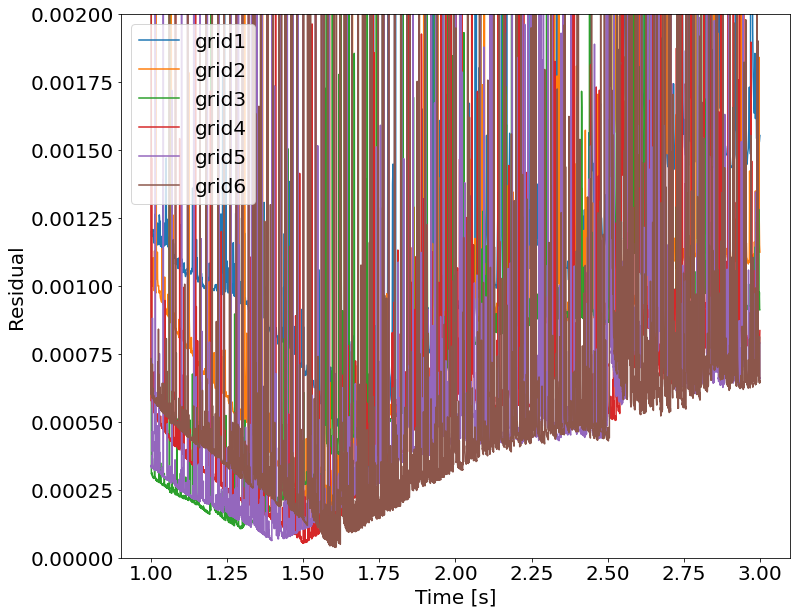

In [4]:

plt.rcParams.update({'font.size':20, 'lines.markersize':10})
fig1, ax1 = plt.subplots(figsize=(12,10))
for i, pressure in enumerate(residual_p):
    ax1.plot(residual_times[i], pressure, label=residual_names[i])

ax1.set_ylabel('Residual')
ax1.set_xlabel('Time [s]')
ax1.set_ylim([0, 0.002])
ax1.legend()

In [5]:
combined_force_file = pio.get_files(data_location, 'combined_forces.xlsx')[0]

xl = pd.ExcelFile(Path(combined_force_file))
case_names = xl.sheet_names

grid = []
average_x = []
average_y = []
average_z = []

for i, name in enumerate(case_names):
    df = pd.read_excel(Path(combined_force_file), sheet_name=name)

    grid.append(df['Grid'].values)
    average_x.append(df['Average_x'].values)
    average_y.append(df['Average_y'].values)
    average_z.append(df['Average_z'].values)

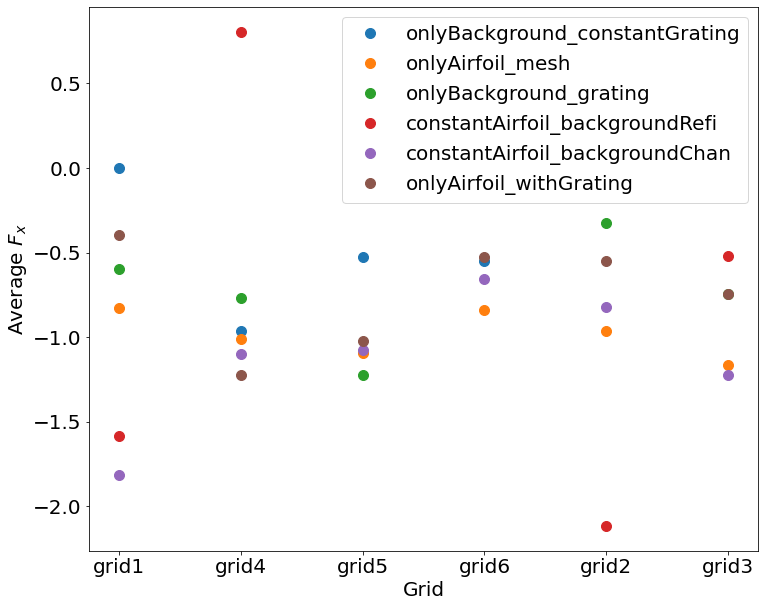

In [6]:
fig2, ax2 = plt.subplots(figsize=(12,10))
for i, name in enumerate(case_names):
    ax2.plot(grid[i], average_x[i], 'o', label=name)

ax2.set_xlabel('Grid')
ax2.set_ylabel('Average $F_x$')
ax2.legend()

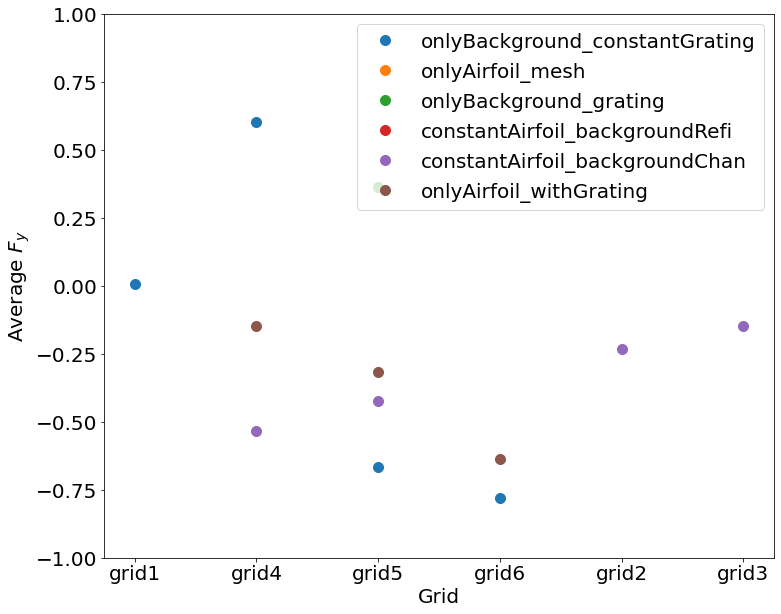

In [7]:
fig3, ax3 = plt.subplots(figsize=(12,10))
for i, name in enumerate(case_names):
    ax3.plot(grid[i], average_y[i], 'o', label=name)

ax3.set_ylim([-1, 1])
ax3.set_xlabel('Grid')
ax3.set_ylabel('Average $F_y$')
ax3.legend()

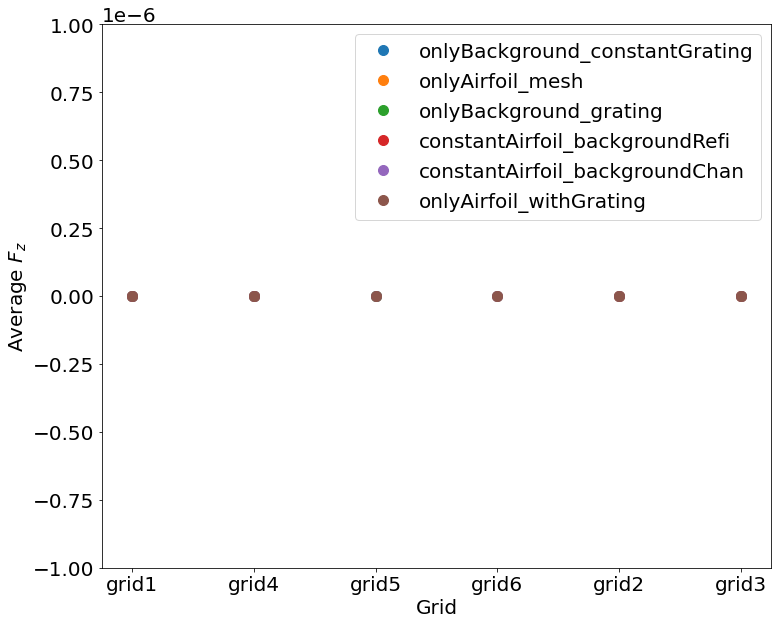

In [8]:
fig4, ax4 = plt.subplots(figsize=(12,10))
for i, name in enumerate(case_names):
    ax4.plot(grid[i], average_z[i], 'o', label=name)

ax4.set_ylim([-0.000001, 0.000001])
ax4.set_xlabel('Grid')
ax4.set_ylabel('Average $F_z$')
ax4.legend()